# Summary

- GPs are just kernel regressions
- WhiteNoise and alpha influence std. deviations
- One-Hot-Variable-Encoding still not clear
- mulitple restartes of improve results (n_restarts_optimizer in gp init)
- prior only influenced by kernel 

In [597]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,ConstantKernel,
                                              ConstantKernel, WhiteKernel)

from sklearn.utils import check_random_state
#y_mean, y_cov = gp.predict(X, return_cov=True)



In [598]:
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),nu=1.5),
          0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=1.09**2)]

In [612]:
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) 
           + WhiteKernel(noise_level=1.09**2),
           0.18**2 * RBF(length_scale=0.134)
           + WhiteKernel(noise_level=1.09**2)]

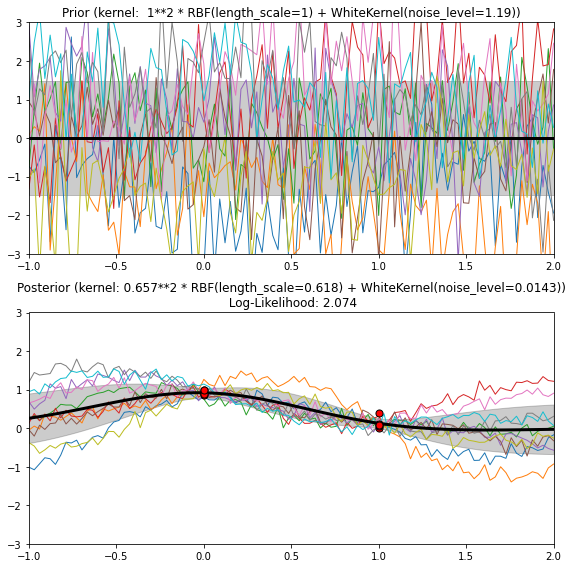

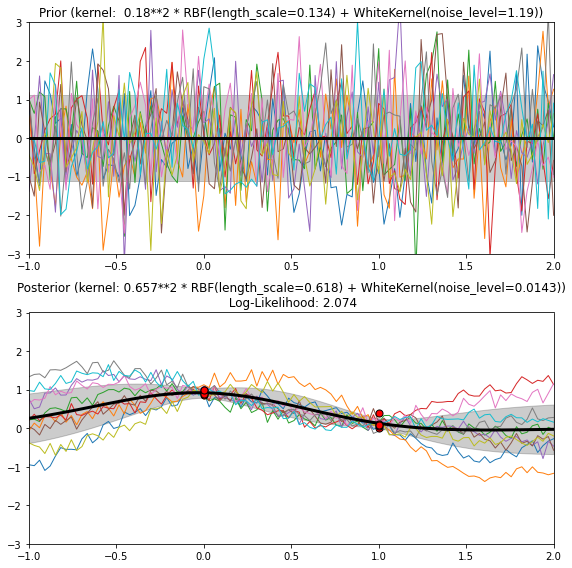

In [615]:
for kernel in kernels:
    #print(kernel)
    #kernel = 0.594**2 * RBF(length_scale=0.279)
    # Specify Gaussian Process
    #kernel_man = 0.594**2 * RBF(length_scale=0.279)
    gp = GaussianProcessRegressor(kernel=kernel, 
                                  n_restarts_optimizer=50)

    # Plot prior
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(-1, 2, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(-1, 2)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 1, 10)[:, np.newaxis]
    X = np.concatenate([np.repeat(0,5)]+[np.repeat(1,5)])
    X = X[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    y = np.array([0.9,0.99,0.85,0.89,0.99, 0.1,0.01, 0.05, 0.07, 0.4])
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(-1, 2, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(-1, 2)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()

In [555]:
def kernel_fct(x1,x2):
    return np.exp(-np.power((x1-x2),2)/2)

In [556]:
X_ = np.linspace(0, 5, 5)
y_cov2 = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        y_cov2[i,j] = kernel_fct(X_[i],X_[j])

In [558]:
y_samples.shape

(100, 10)

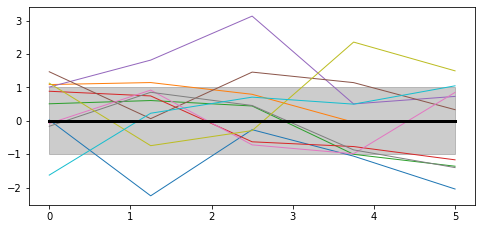

In [560]:
gp = GaussianProcessRegressor(kernel=kernel)

# Plot prior
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
X_ = np.linspace(0, 5, 5)
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)


plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
rng = check_random_state(0)
y_samples = rng.multivariate_normal(y_mean, y_cov, 10).T
#y_samples = gp.sample_y(X_[:, np.newaxis], 10)
plt.plot(X_, y_samples, lw=1);
#plt.xlim(0, 5)
#plt.ylim(-3, 3)
#plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

In [561]:
from scipy.linalg import cho_factor, cho_solve, inv, cholesky

In [562]:
kernel_man = 0.594**2 * RBF(length_scale=0.279)
#kernel_man = 1 * RBF(length_scale=1)

In [563]:
X

array([[0.   ],
       [0.025],
       [0.05 ],
       [0.075],
       [0.1  ],
       [1.   ],
       [1.025],
       [1.05 ],
       [1.075],
       [1.1  ]])

In [564]:
K = kernel_man(X)
K[np.diag_indices_from(K)] += 1e-10
K.shape

(10, 10)

In [565]:
inv(K)@y

array([-1.77054220e+07,  7.07484359e+07, -1.06950390e+08,  7.24972086e+07,
       -1.85944437e+07,  1.03802181e+07, -3.95276956e+07,  5.69825008e+07,
       -3.68524933e+07,  9.02089657e+06])

In [566]:
L_ = cholesky(K, lower=True)

In [567]:
alpha_ = cho_solve((L_ , True), y)
alpha_

array([-1.77054211e+07,  7.07484320e+07, -1.06950384e+08,  7.24972044e+07,
       -1.85944426e+07,  1.03802159e+07, -3.95276872e+07,  5.69824883e+07,
       -3.68524851e+07,  9.02089451e+06])

In [568]:
K_trans = kernel_man(X_[:, np.newaxis],X)
#K_trans

In [569]:
y_mean = K_trans.dot(alpha_)  # Line 4 (y_mean = f_star)
y_mean

array([9.01770547e-01, 1.17256385e+01, 1.68682616e-01, 8.41111609e-15,
       2.99559540e-37])

In [570]:
# undo normalisation
y_mean = gp._y_train_std * y_mean + gp._y_train_mean

AttributeError: 'GaussianProcessRegressor' object has no attribute '_y_train_std'

In [571]:
#
v = cho_solve((L_, True), K_trans.T)  # Line 5
y_cov = kernel_man(X_[:, np.newaxis]) - K_trans.dot(v)  # Line 6
y_cov

array([[ 9.96895344e-11, -2.26077325e-10, -1.38913312e-11,
        -7.46164598e-25, -2.72468952e-47],
       [-2.26077595e-10,  1.46822286e-04,  5.04757610e-06,
         1.05242196e-18,  2.01549881e-40],
       [-1.38913472e-11,  5.04757610e-06,  3.52835982e-01,
         1.54448252e-05,  1.29542812e-18],
       [-7.46162113e-25,  1.05242196e-18,  1.54448252e-05,
         3.52836000e-01,  1.54448252e-05],
       [-2.72468563e-47,  2.01549881e-40,  1.29542812e-18,
         1.54448252e-05,  3.52836000e-01]])

In [572]:
k_star = kernel_man(X_[:, np.newaxis])
y_cov =  k_star-K_trans@inv(K)@K_trans.T
y_cov

array([[ 4.38726690e-08, -1.41267767e-07, -9.09549701e-10,
        -4.17726525e-23, -1.44428748e-45],
       [ 5.14541792e-09,  1.46809499e-04,  5.04757552e-06,
         1.05242193e-18,  2.01549880e-40],
       [-1.38567478e-11,  5.04757566e-06,  3.52835982e-01,
         1.54448252e-05,  1.29542812e-18],
       [-7.45984737e-25,  1.05242194e-18,  1.54448252e-05,
         3.52836000e-01,  1.54448252e-05],
       [-2.72459964e-47,  2.01549880e-40,  1.29542812e-18,
         1.54448252e-05,  3.52836000e-01]])

In [573]:
y_cov = y_cov * gp._y_train_std**2

AttributeError: 'GaussianProcessRegressor' object has no attribute '_y_train_std'

In [574]:
y_cov

array([[ 4.38726690e-08, -1.41267767e-07, -9.09549701e-10,
        -4.17726525e-23, -1.44428748e-45],
       [ 5.14541792e-09,  1.46809499e-04,  5.04757552e-06,
         1.05242193e-18,  2.01549880e-40],
       [-1.38567478e-11,  5.04757566e-06,  3.52835982e-01,
         1.54448252e-05,  1.29542812e-18],
       [-7.45984737e-25,  1.05242194e-18,  1.54448252e-05,
         3.52836000e-01,  1.54448252e-05],
       [-2.72459964e-47,  2.01549880e-40,  1.29542812e-18,
         1.54448252e-05,  3.52836000e-01]])

In [575]:
# undo normalisation
y_cov = y_cov * gp._y_train_std**2

AttributeError: 'GaussianProcessRegressor' object has no attribute '_y_train_std'

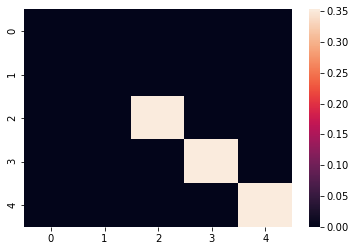

In [576]:
ax = sns.heatmap(y_cov)

<ipython-input-577-86fbc9b4327a>:2: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, 10).T


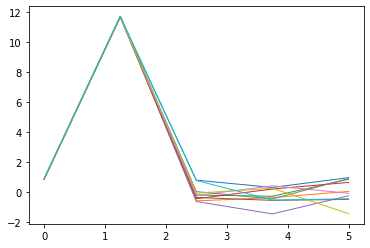

In [577]:
rng = check_random_state(0)
y_samples = rng.multivariate_normal(y_mean, y_cov, 10).T
plt.plot(X_, y_samples, lw=1);

In [578]:
kernel_man = 0.594**2 * RBF(length_scale=0.279)
#kernel_man = ConstantKernel(1.0, constant_value_bounds="fixed")

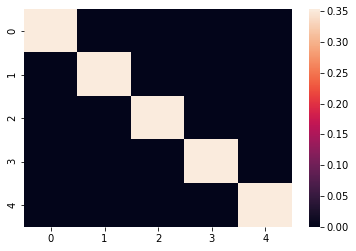

In [579]:
ax = sns.heatmap(kernel_man(X_[:, np.newaxis]))

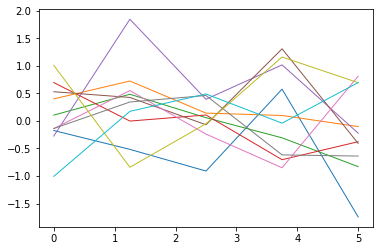

In [580]:
rng = check_random_state(0)
y_samples = rng.multivariate_normal(np.zeros(X_.shape[0]), 
                                    kernel_man(X_[:, np.newaxis]), 10).T
plt.plot(X_, y_samples, lw=1);

In [581]:
X = np.concatenate([np.repeat(0,5)]+[np.repeat(1,5)])

In [582]:
np.sin((X[:, 0] - 2.5) ** 2)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [591]:
y_mean, y_std = gp.predict(np.array((0,1))[:, np.newaxis], return_std=True)

In [594]:
y_std

array([0.19558454, 0.19558454])

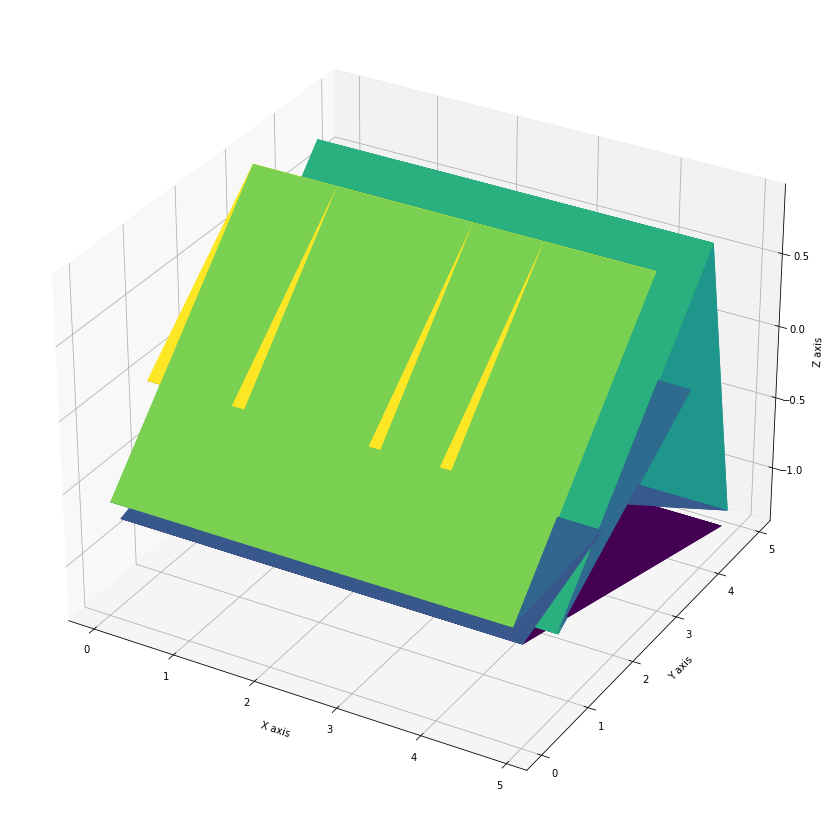

In [593]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

#Parameters to set
gp = GaussianProcessRegressor(kernel=kernel)

# Generate data and fit GP
rng = np.random.RandomState(4)
x = rng.uniform(0, 5, 10)[:, np.newaxis]
z = rng.uniform(0, 5, 10)[:, np.newaxis]
y = np.sin((x[:, 0] - 2.5) ** 2)
X, Y = np.meshgrid(x,z)
gp.fit(X, y)

#Create grid and multivariate normal
#x = np.linspace(-10,10,500)
#y = np.linspace(-10,10,500)
#X, Y = np.meshgrid(x,y)


y_mean, y_cov = gp.predict(X, return_cov=True)
y_samples = gp.sample_y(X, 1)

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, y_samples,cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [190]:
y_cov.shape

(500, 500)

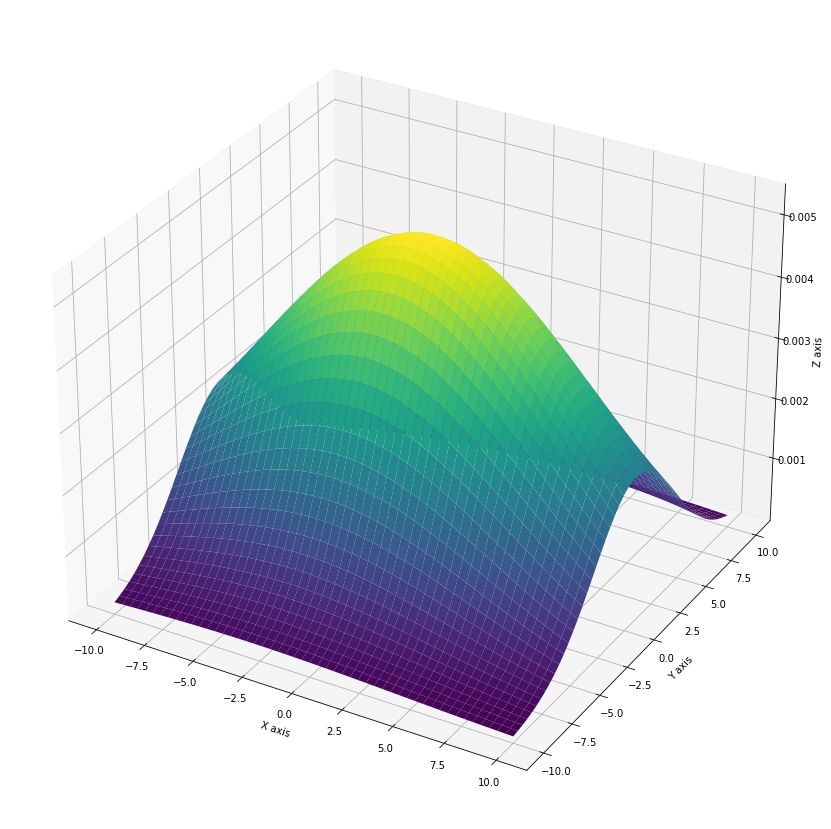

In [173]:

plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
y_samples = gp.sample_y(X_[:, np.newaxis], 10)
plt.plot(X_, y_samples, lw=1)
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)
    
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, 20], [5, variance_y]])

#Make a 3D plot
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()